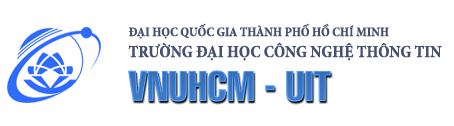



**ĐỒ ÁN CUỐI KỲ MÔN MÁY HỌC - CS114.N21**

---



**BÀI TOÁN: DỰ ĐOÁN GIỚI TÍNH CỦA MỘT NGƯỜI DỰA VÀO HỌ TÊN NGƯỜI ĐÓ**

`Lớp: CS114.N21`

`GV hướng dẫn: TS. Lê Đình Duy, ThS. Phạm Nguyễn Trường An	`

`Thành viên nhóm HKV:`



`1.   Nguyễn Trung Kiên - 21521024`

`2.   Nguyễn Sỹ Hùng - 21522119`

`3.   Phạm Quốc Việt - 21522792`


`Tp. HCM, tháng 7 năm 2023`

**`Mục lục`**

`I. Tổng quan đồ án`

`II. Xây dựng bộ dữ liệu`

`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`

`IV. Kết luận`



##**`I. Tổng quan đồ án`**

###`1.1. Mô tả bài toán`

`Đề tài dự đoán giới tính một người dựa vào họ tên là đề tài hướng đến việc sử dụng họ và tên của một người để có thể phân loại người đó là nam hay nữ. Trong Machine Learning, đây là dạng bài toán có tên gọi Binary Classification, trong đó bài toán chỉ có hai classes, cũng là hai giới tính cần được phân loại.`

###**`1.2. Input và output của bài toán`**

`- Input: Dataset bao gồm họ và tên và giới tính tương ứng, họ tên người cần dự đoán giới tính.`

`- Output: Giới tính được dự đoán của người đó`

###**`1.3. Các thuật toán máy học mà đồ án sử dụng`**

`Trong bài báo cáo, nhóm sẽ sử dụng 4 mô hình classification, đó là: Logistics Regression, SVM, Gaussian Naive Bayes và Decision Tree. Sau khi qua các bước xử lý dữ liệu và trích chọn đặc trưng, data được xử lý sẽ đưa vào các mô hình classification và sau cùng đánh giá từng mô hình bằng confusion matrix và giá trị của các metrics: accuracy, precision, recall và f1-score.`

###**`1.4. Các tiêu chí về một mô hình được đánh giá tốt`**

`Tiêu chí mà nhóm sử dụng để đánh giá một mô hình có thể xem là tốt đó là:`

`f1-score: f1- score là giá trị trung bình điều hòa của precision và recall. Hiểu một cách đơn giản, f1-score cân bằng hai giá trị precision và recall. Đôi khi trong một số trường hợp, tập dữ liệu quá nghiêng về trường hợp positive, giá trị precision sẽ cao nhưng recall thấp, và ngược lại. Hiện tượng này thường được đề cập với tên gọi precision-recall trade-off. Do đó, để tránh việc này, f1-score phải cao thì mới tương ứng với precision cao và recall cao. Qua những nghiên cứu trước đây đã được thực hiện, nhóm hi vọng f1-score của nhóm đạt trên 95%.`


##**`II. Xây dựng bộ dữ liệu`**

`Trước tiên, nhóm sẽ khai báo các package cần thiết sẽ sử dụng cho bài toán như sau: `



In [1]:
!pip install transformers
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, logging
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

`Đọc file json lấy từ dataset của nhóm trên github`

In [2]:
data = pd.read_json("https://raw.githubusercontent.com/kiendoo4/final-project/main/dataset/dataset_tc.json")
print(data)

                  full_name  gender
0             Ngô Xuân Tùng       1
1         Bùi Dương Thảo Vy       0
2               Lưu Thế Huy       1
3            Nguyễn Thị Vân       0
4           Dương Minh Long       1
...                     ...     ...
26846      Đoàn Thị Bảo Thu       0
26847            Ôn Hoa Thu       1
26848  Nguyễn Thị Huỳnh Như       0
26849  Nguyễn Thị Hồng Phúc       0
26850         Dương Mỹ Uyên       0

[26851 rows x 2 columns]


`Mô tả về bộ dataset`

`- Số lượng nam, nữ giới và còn lại trong bộ data lần lượt là: 16613, 12188 và 0, số lượng nam và nữ giới trong dataset gần bằng nhau để phần nào tránh được tình trạng information bias`

In [3]:
#Number of males, females and others in data, and the length of data
male = 0
female = 0
other = 0
for line in data["gender"]:
  if line == 1:
    male += 1
  elif line == 0:
    female += 1
  else:
    print(line)
    other += 1
print("Number of males, females and others in data: %s, %s, %s" % (male, female, other))
print("Length of data: %s" % len(data["gender"]))

Number of males, females and others in data: 15494, 11357, 0
Length of data: 26851


`Số lượng họ và tên không trùng trong dataset được lọc ra là 19431. Việc lọc bỏ các dữ liệu trùng lặp cũng sẽ tránh việc information bias. Sau cùng, ta được data chứa một bộ các họ và tên không có bất kỳ bộ đôi họ và tên nào trùng lặp với nhau`

`Tách data ra làm 2 phần: X tương ứng với họ và tên và y tương ứng với giá trị đã quy định cho giới tính, 0 là nữ giới, và 1 ứng với nam giới`

In [4]:
X = data["full_name"]
y = data["gender"]

In [5]:
print(X)

0               Ngô Xuân Tùng
1           Bùi Dương Thảo Vy
2                 Lưu Thế Huy
3              Nguyễn Thị Vân
4             Dương Minh Long
                 ...         
26846        Đoàn Thị Bảo Thu
26847              Ôn Hoa Thu
26848    Nguyễn Thị Huỳnh Như
26849    Nguyễn Thị Hồng Phúc
26850           Dương Mỹ Uyên
Name: full_name, Length: 26851, dtype: object


In [6]:
print(y)

0        1
1        0
2        1
3        0
4        1
        ..
26846    0
26847    1
26848    0
26849    0
26850    0
Name: gender, Length: 26851, dtype: int64


##**`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`**

`Trước tiên, ta chia dữ liệu để xử lý các bước kế tiếp, tỉ lệ 80/20 tương ứng với data để train và data để test`

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#### `3.2. Bag of words (BoW)`

##### `Quá trình khởi tạo mô hình`

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
X = data['full_name']
y = data['gender']

In [10]:
processed_names = []
for name in X:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

`Xây dựng từ điển từ các từ trong tên đầy đủ`

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [12]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

Vocabulary size: {} 1525
Vocabualry content:
 {} {'ngô': 696, 'xuân': 1406, 'tùng': 1283, 'bùi': 53, 'dương': 222, 'thảo': 1120, 'vy': 1360, 'lưu': 565, 'thế': 1132, 'huy': 301, 'nguyễn': 687, 'thị': 1135, 'vân': 1364, 'minh': 609, 'long': 519, 'trần': 1232, 'mai': 601, 'khanh': 423, 'hồng': 388, 'diệp': 193, 'hoàng': 295, 'khang': 422, 'thi': 1042, 'ngọc': 704, 'thái': 1083, 'anh': 5, 'tường': 1295, 'nhật': 759, 'lê': 546, 'trúc': 1217, 'quỳnh': 938, 'đức': 1514, 'tấn': 1303, 'đào': 1458, 'hiếu': 277, 'thạch': 1114, 'kim': 456, 'yến': 1414, 'võ': 1367, 'thanh': 1037, 'phạm': 855, 'lệ': 585, 'chi': 95, 'đỗ': 1509, 'nghĩa': 672, 'đinh': 1439, 'dân': 212, 'huỳnh': 316, 'lý': 557, 'chương': 121, 'lương': 566, 'việt': 1353, 'mạnh': 638, 'nhi': 721, 'quốc': 937, 'khánh': 439, 'trịnh': 1239, 'trung': 1200, 'tiến': 1161, 'đạt': 1478, 'giàu': 251, 'đặng': 1487, 'duy': 201, 'mỹ': 654, 'linh': 508, 'phúc': 849, 'trang': 1185, 'văn': 1368, 'thông': 1096, 'hồ': 384, 'nhơn': 747, 'phan': 820, 'như'

`Chia bộ dữ liệu thành tập huấn luyện và tập kiểm tra`

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [14]:
print(X)

  (0, 696)	1
  (0, 1406)	1
  (0, 1283)	1
  (1, 53)	1
  (1, 222)	1
  (1, 1120)	1
  (1, 1360)	1
  (2, 565)	1
  (2, 1132)	1
  (2, 301)	1
  (3, 687)	1
  (3, 1135)	1
  (3, 1364)	1
  (4, 222)	1
  (4, 609)	1
  (4, 519)	1
  (5, 1232)	1
  (5, 601)	1
  (5, 423)	1
  (6, 687)	1
  (6, 1135)	1
  (6, 388)	1
  (6, 193)	1
  (7, 687)	1
  (7, 295)	1
  :	:
  (26844, 1135)	1
  (26844, 1364)	1
  (26844, 855)	1
  (26844, 167)	1
  (26845, 1135)	1
  (26845, 307)	1
  (26845, 794)	1
  (26846, 1135)	1
  (26846, 1065)	1
  (26846, 1451)	1
  (26846, 65)	1
  (26847, 1065)	1
  (26847, 286)	1
  (26847, 1428)	1
  (26848, 687)	1
  (26848, 1135)	1
  (26848, 316)	1
  (26848, 748)	1
  (26849, 687)	1
  (26849, 1135)	1
  (26849, 388)	1
  (26849, 849)	1
  (26850, 222)	1
  (26850, 654)	1
  (26850, 1330)	1


##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

######`Huấn luyện mô hình Logistic Regression`

In [15]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.96083   0.93147   0.94592      2291
           1    0.95016   0.97175   0.96083      3080

    accuracy                        0.95457      5371
   macro avg    0.95549   0.95161   0.95338      5371
weighted avg    0.95471   0.95457   0.95447      5371

Precision score of using Logistic Regression: 0.9554935929046691
Recall score of using Logistic Regression: 0.9516121100636596
F1-score of using Logistic Regression: 0.9533783283813168


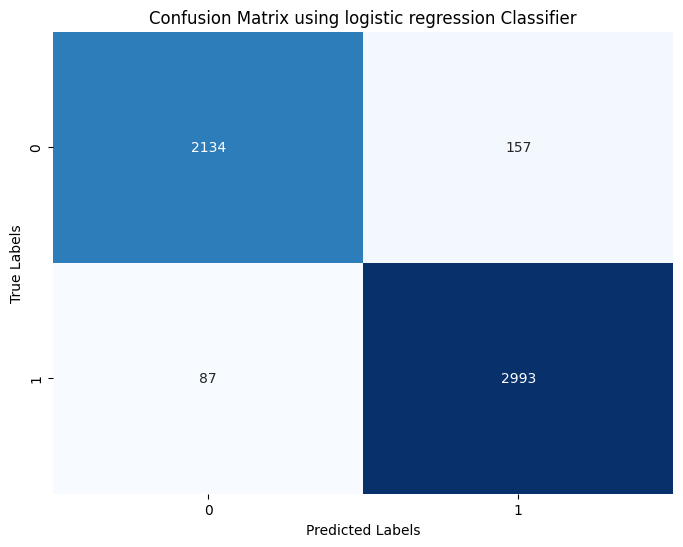

In [17]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Huấn luyện mô hình SVM`

In [18]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, svm_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, svm_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, svm_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, svm_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

              precision    recall  f1-score   support

           0    0.96112   0.92798   0.94426      2291
           1    0.94777   0.97208   0.95977      3080

    accuracy                        0.95327      5371
   macro avg    0.95444   0.95003   0.95201      5371
weighted avg    0.95346   0.95327   0.95315      5371

Precision score of using SVM: 0.9544447192126517
Recall score of using SVM: 0.9500284852641903
F1-score of using SVM 0.9520142882074272


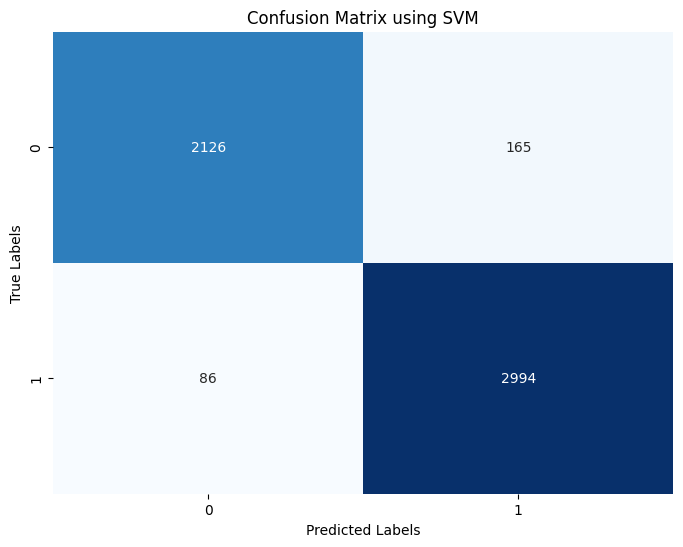

In [19]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Decision Tree`

In [20]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [21]:
print(classification_report(y_test, dt_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, dt_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, dt_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, dt_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.91801   0.91881   0.91841      2291
           1    0.93957   0.93896   0.93927      3080

    accuracy                        0.93037      5371
   macro avg    0.92879   0.92889   0.92884      5371
weighted avg    0.93037   0.93037   0.93037      5371

Precision score of using DecisionTreeClassifier model: 0.9287912444774289
Recall score of using DecisionTreeClassifier model: 0.9288868922435051
F1-score of using DecisionTreeClassifier model 0.928838931408908


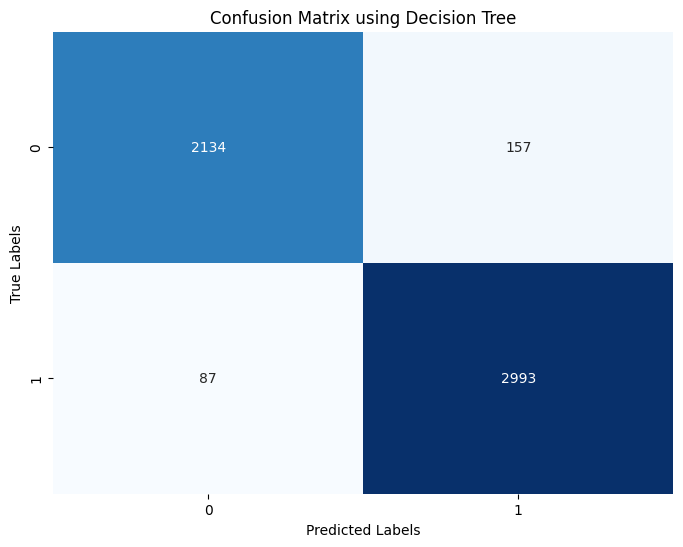

In [22]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Gaussian Naive Bayes`

In [23]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [24]:
print(classification_report(y_test, nb_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, nb_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, nb_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, nb_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.54951   0.97381   0.70257      2291
           1    0.95423   0.40617   0.56980      3080

    accuracy                        0.64830      5371
   macro avg    0.75187   0.68999   0.63618      5371
weighted avg    0.78160   0.64830   0.62643      5371

Precision score of using GaussianNB model: 0.7518703993867728
Recall score of using GaussianNB model: 0.6899896971208626
F1-score of using GaussianNB model 0.6361841962064301


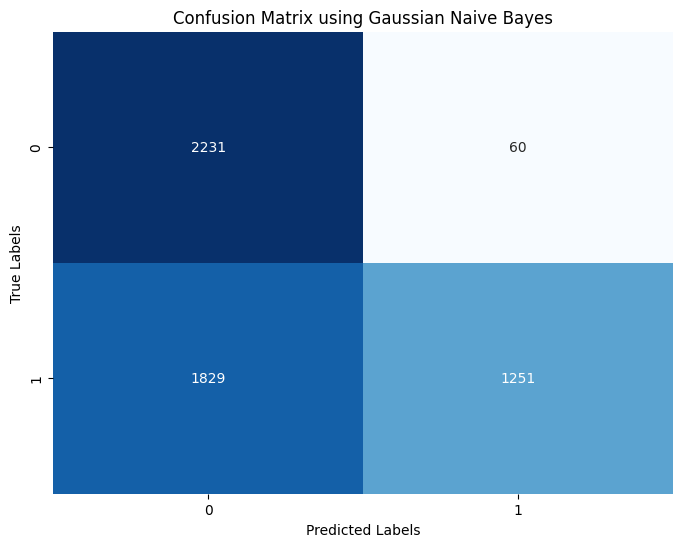

In [25]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### `Trường hợp xoá bỏ họ ra khỏi họ và tên`

###### `Code`

`Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau`

In [26]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

In [27]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Xuân Tùng', 'Thảo Vy', 'Thế Huy', 'Thị Vân', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Hoàng Khang', 'Ngọc Thái', 'Anh Huy', 'Tường Vy', 'Minh Nhật', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Đức Mạnh', 'Yến Nhi', 'Quốc Khánh', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Quốc Duy', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Văn Khánh', 'Minh Thông', 'Hiếu Nhơn', 'Minh Dương', 'Quỳnh Như', 'Anh Hiếu', 'Văn Trọng', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Huy Hoàng', 'Thúy Kiều', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Quốc Anh', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thùy Linh', 'Thiên Phước', 'Quang Tuấn', 'Thanh Tuyền', 'Xuân Tùng', 'Huy Phong', 'Ngọc Giàu', 'Như Minh', 'Thanh Quí', 'Trọng Tài', 'Công Danh', 'Quang Hào', 'Hữu Tài', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Huyền Trân', 

In [28]:
y = data['gender']

In [29]:
processed_names = []
for name in X_erase_surname:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

In [30]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [31]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

Vocabulary size: {} 1250
Vocabualry content:
 {} {'xuân': 1159, 'tùng': 1052, 'thảo': 911, 'vy': 1118, 'thế': 922, 'huy': 257, 'thị': 925, 'vân': 1122, 'minh': 491, 'long': 424, 'mai': 485, 'khanh': 341, 'hồng': 318, 'diệp': 157, 'hoàng': 252, 'khang': 340, 'ngọc': 570, 'thái': 877, 'anh': 4, 'tường': 1063, 'nhật': 623, 'trúc': 994, 'quỳnh': 754, 'đức': 1242, 'tấn': 1070, 'hiếu': 235, 'kim': 370, 'yến': 1166, 'thanh': 834, 'lệ': 475, 'chi': 74, 'nghĩa': 540, 'dân': 175, 'chương': 95, 'việt': 1113, 'mạnh': 512, 'nhi': 586, 'quốc': 753, 'khánh': 355, 'trung': 980, 'tiến': 948, 'đạt': 1217, 'giàu': 213, 'duy': 165, 'mỹ': 526, 'linh': 413, 'phúc': 695, 'trang': 968, 'văn': 1125, 'thông': 888, 'nhơn': 611, 'dương': 185, 'như': 612, 'trọng': 1011, 'ngôn': 565, 'thiện': 848, 'huân': 265, 'thúy': 893, 'kiều': 376, 'đình': 1201, 'diệu': 158, 'hiền': 236, 'đại': 1215, 'thu': 860, 'thủy': 937, 'khảo': 363, 'xương': 1161, 'tú': 1053, 'sec': 783, 'váy': 1121, 'huỳnh': 272, 'duyên': 166, 'uyên': 109

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

###### `Huấn luyện mô hình Logistic Regression`

In [33]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.93851   0.91270   0.92543      2291
           1    0.93637   0.95552   0.94585      3080

    accuracy                        0.93726      5371
   macro avg    0.93744   0.93411   0.93564      5371
weighted avg    0.93728   0.93726   0.93714      5371

Precision score of using Logistic Regression: 0.9374382015604481
Recall score of using Logistic Regression: 0.9341106787145634
F1-score of using Logistic Regression: 0.935636017078177


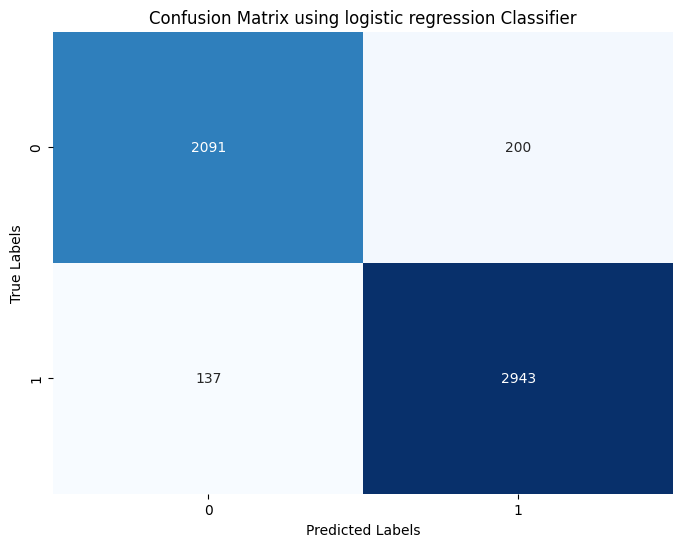

In [35]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình SVM`

In [36]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, svm_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, svm_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, svm_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, svm_pred, average='macro'))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

              precision    recall  f1-score   support

           0    0.93644   0.91314   0.92464      2291
           1    0.93656   0.95390   0.94515      3080

    accuracy                        0.93651      5371
   macro avg    0.93650   0.93352   0.93490      5371
weighted avg    0.93651   0.93651   0.93640      5371

Precision score of using SVM: 0.9365002401521221
Recall score of using SVM: 0.9335172357106011
F1-score of using SVM 0.9348956390293235


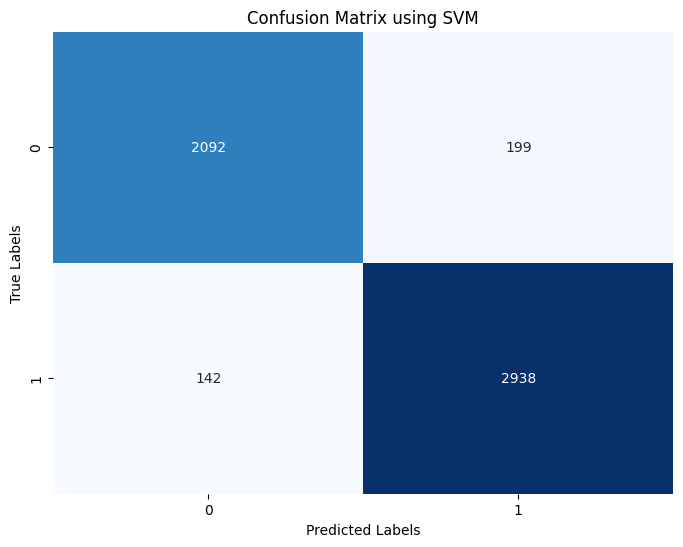

In [37]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Decision Tree`

In [38]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [39]:
print(classification_report(y_test, dt_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, dt_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, dt_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, dt_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.89146   0.90703   0.89918      2291
           1    0.92993   0.91786   0.92386      3080

    accuracy                        0.91324      5371
   macro avg    0.91070   0.91244   0.91152      5371
weighted avg    0.91352   0.91324   0.91333      5371

Precision score of using DecisionTreeClassifier model: 0.9106985509946036
Recall score of using DecisionTreeClassifier model: 0.9124423208829582
F1-score of using DecisionTreeClassifier model 0.9115170271195165


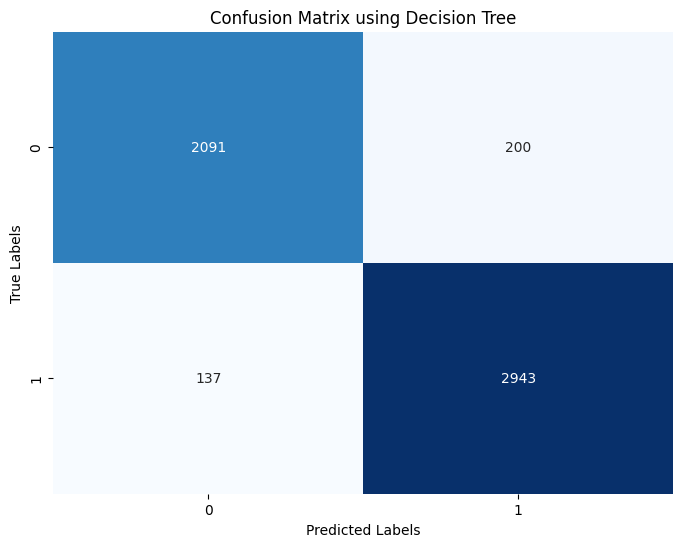

In [40]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Huấn luyện mô hình Gaussian Naive Bayes`

In [41]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [42]:
print(classification_report(y_test, nb_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, nb_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, nb_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, nb_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.57574   0.97381   0.72365      2291
           1    0.95989   0.46623   0.62762      3080

    accuracy                        0.68274      5371
   macro avg    0.76782   0.72002   0.67563      5371
weighted avg    0.79603   0.68274   0.66858      5371

Precision score of using GaussianNB model: 0.7678174918061066
Recall score of using GaussianNB model: 0.72002216465333
F1-score of using GaussianNB model 0.6756340885841372


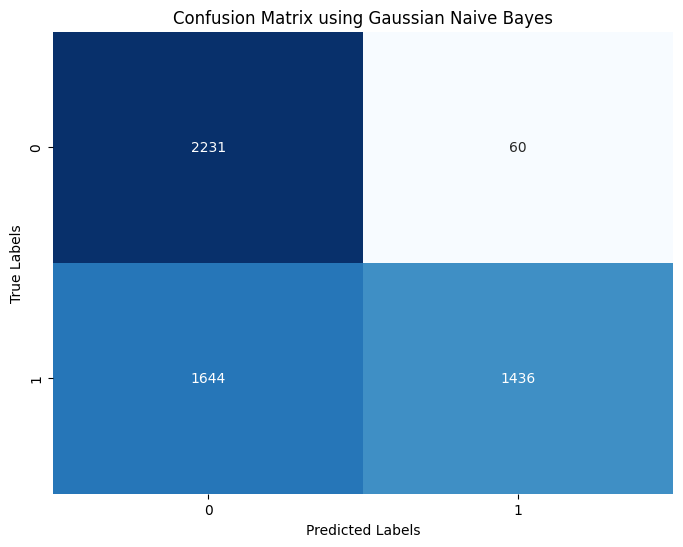

In [43]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.3. Bag of n-grams`

##### `Quá trình khởi tạo mô hình`

In [44]:
X = data["full_name"]
y = data["gender"]

`Bag of n-grams là một mô hình tương tự như Bag of Words, chỉ khác một điều là mô hình này là một tập hợp các cụm phần tử có chuỗi n phần tử liền kề với nhau từ một văn bản cho trước. Nếu n = 1 (unigram) thì ta có thể xem đây là bag of words. Các phần tử có thể là các từ, chữ cái, âm tiết,...`

`Ví dụ: ta có một câu như sau: "Xin chào thế giới."`

`Với unigram (n = 1): "Xin", "chào", "thế", "giới"`

`Với bigram (n = 2): "Xin chào", "chào thế", "thế giới"`
`Với trigram (n = 3): "Xin chào thế", "chào thế giới"`



`Trong thư viện sklearn.feature_extraction.text có một hàm là CountVectorizer(), ta dùng hàm này để áp dụng mô hình Bag of n-grams cho đồ án.`



In [45]:
from sklearn.feature_extraction.text import CountVectorizer

`Ta dùng hàm CountVectorizer() với ngram_range=(2, 3)) - n thuộc khoảng từ 2 -> 3`

In [46]:
cv = CountVectorizer(ngram_range=(2, 3))

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [47]:
X_convert = cv.fit_transform(np.array(X))

`Hiển thị từ điển cụm từ`

In [48]:
print(cv.vocabulary_)

{'ngô xuân': 16595, 'xuân tùng': 32096, 'ngô xuân tùng': 16604, 'bùi dương': 541, 'dương thảo': 3076, 'thảo vy': 22525, 'bùi dương thảo': 545, 'dương thảo vy': 3078, 'lưu thế': 10322, 'thế huy': 22572, 'lưu thế huy': 10323, 'nguyễn thị': 14597, 'thị vân': 24844, 'nguyễn thị vân': 14806, 'dương minh': 2931, 'minh long': 11273, 'dương minh long': 2938, 'trần mai': 26924, 'mai khanh': 10912, 'trần mai khanh': 26927, 'thị hồng': 23213, 'hồng diệp': 6401, 'nguyễn thị hồng': 14669, 'thị hồng diệp': 23220, 'nguyễn hoàng': 12559, 'hoàng khang': 3754, 'nguyễn hoàng khang': 12585, 'thi ngọc': 21500, 'ngọc thái': 17073, 'thi ngọc thái': 21501, 'nguyễn anh': 12034, 'anh huy': 68, 'nguyễn anh huy': 12040, 'nguyễn mai': 13325, 'mai tường': 11105, 'tường vy': 29114, 'nguyễn mai tường': 13341, 'mai tường vy': 11106, 'nguyễn minh': 13344, 'minh nhật': 11313, 'nguyễn minh nhật': 13402, 'lê trúc': 9457, 'trúc quỳnh': 25648, 'lê trúc quỳnh': 9459, 'ngô minh': 16260, 'minh đức': 11470, 'ngô minh đức': 1628

`Làm quen với X đã được chuyển đổi`

In [49]:
print(X_convert)

  (0, 16595)	1
  (0, 32096)	1
  (0, 16604)	1
  (1, 541)	1
  (1, 3076)	1
  (1, 22525)	1
  (1, 545)	1
  (1, 3078)	1
  (2, 10322)	1
  (2, 22572)	1
  (2, 10323)	1
  (3, 14597)	1
  (3, 24844)	1
  (3, 14806)	1
  (4, 2931)	1
  (4, 11273)	1
  (4, 2938)	1
  (5, 26924)	1
  (5, 10912)	1
  (5, 26927)	1
  (6, 14597)	1
  (6, 23213)	1
  (6, 6401)	1
  (6, 14669)	1
  (6, 23220)	1
  :	:
  (26844, 22900)	1
  (26845, 23089)	1
  (26845, 17669)	1
  (26845, 17673)	1
  (26846, 32907)	1
  (26846, 22784)	1
  (26846, 1215)	1
  (26846, 32910)	1
  (26846, 22795)	1
  (26847, 32283)	1
  (26847, 3488)	1
  (26847, 32284)	1
  (26848, 14597)	1
  (26848, 23115)	1
  (26848, 4804)	1
  (26848, 23127)	1
  (26848, 14653)	1
  (26849, 14597)	1
  (26849, 23213)	1
  (26849, 14669)	1
  (26849, 6497)	1
  (26849, 23263)	1
  (26850, 11794)	1
  (26850, 2954)	1
  (26850, 2958)	1


`Chia data thành 80% bộ train và 20% bộ test`

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42, shuffle=False)

##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

###### `SVM`

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.97188   0.81449   0.88625      2291
           1    0.87685   0.98247   0.92666      3080

    accuracy                        0.91082      5371
   macro avg    0.92436   0.89848   0.90645      5371
weighted avg    0.91738   0.91082   0.90942      5371

Precision score of using SVM: 0.9243611453201971
Recall score of using SVM: 0.8984795104502656
F1-score of using SVM 0.9064538882768738


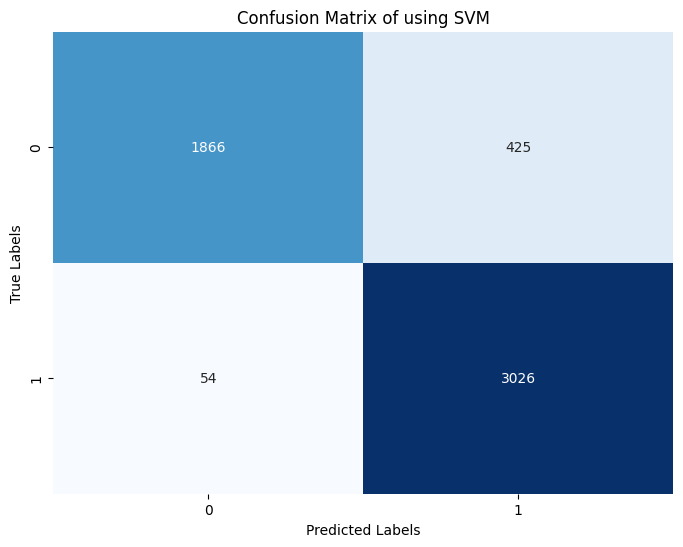

In [51]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Logistic Regression`

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0    0.97591   0.79572   0.87665      2291
           1    0.86640   0.98539   0.92207      3080

    accuracy                        0.90449      5371
   macro avg    0.92116   0.89056   0.89936      5371
weighted avg    0.91311   0.90449   0.90270      5371

Precision score of using Logistic Regression: 0.9211551463077534
Recall score of using Logistic Regression: 0.8905560011790915
F1-score of using Logistic Regression: 0.8993625226211459


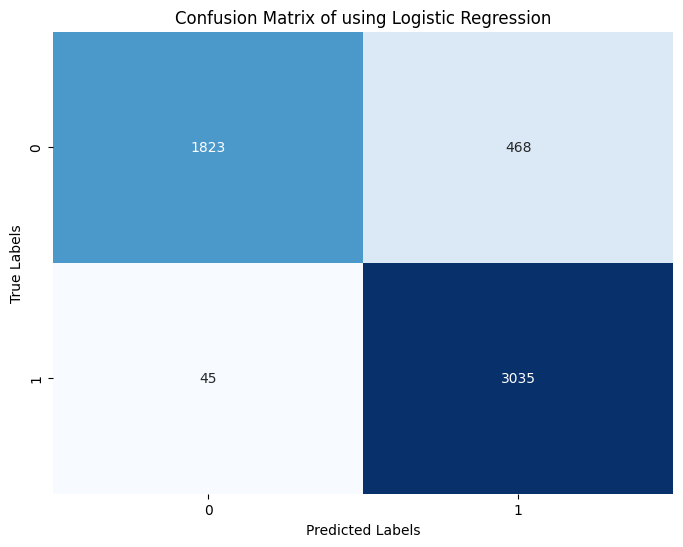

In [52]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Gaussian Naive Bayes`

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.73619   0.95984   0.83327      2291
           1    0.96141   0.74416   0.83895      3080

    accuracy                        0.83616      5371
   macro avg    0.84880   0.85200   0.83611      5371
weighted avg    0.86534   0.83616   0.83652      5371

Precision score of using GaussianNB model: 0.8487997766608323
Recall score of using GaussianNB model: 0.8519993537671408
F1-score of using GaussianNB model 0.8361080026652804


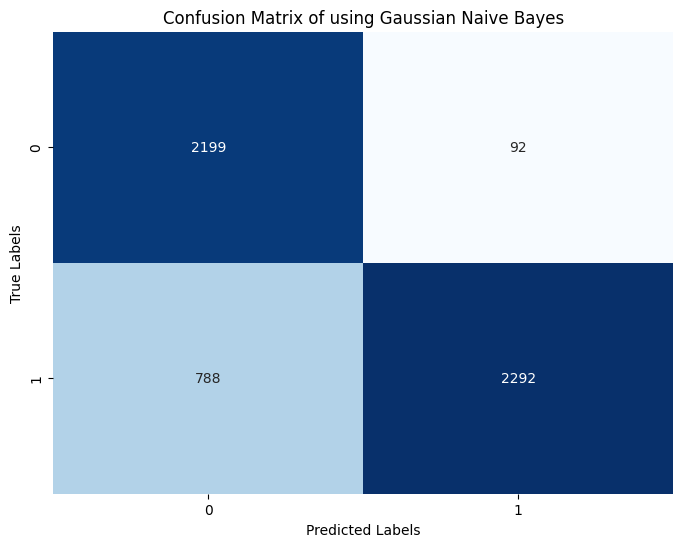

In [53]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Decision Tree Classifier`

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.93875   0.82278   0.87695      2291
           1    0.87927   0.96006   0.91790      3080

    accuracy                        0.90151      5371
   macro avg    0.90901   0.89142   0.89742      5371
weighted avg    0.90464   0.90151   0.90043      5371

Precision score of using DecisionTreeClassifier model: 0.909009738625042
Recall score of using DecisionTreeClassifier model: 0.8914248725957588
F1-score of using DecisionTreeClassifier model 0.8974217589088086


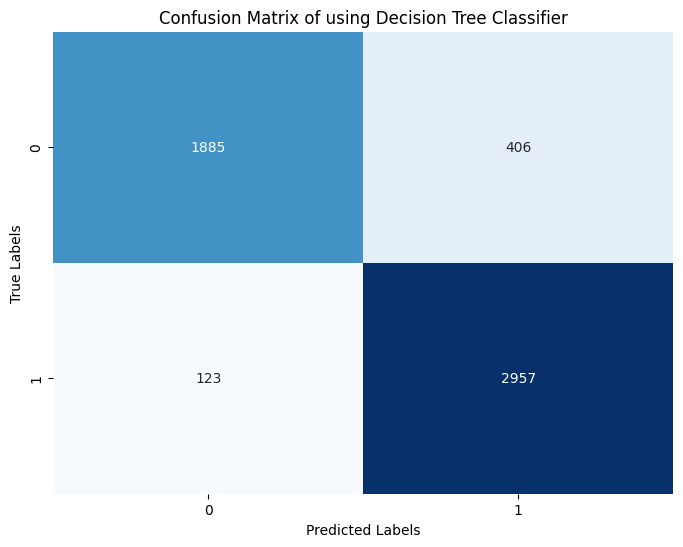

In [54]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### `Trường hợp xoá bỏ họ ra khỏi họ và tên`

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`

###### `Code`

In [55]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Xuân Tùng', 'Thảo Vy', 'Thế Huy', 'Thị Vân', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Hoàng Khang', 'Ngọc Thái', 'Anh Huy', 'Tường Vy', 'Minh Nhật', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Đức Mạnh', 'Yến Nhi', 'Quốc Khánh', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Quốc Duy', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Văn Khánh', 'Minh Thông', 'Hiếu Nhơn', 'Minh Dương', 'Quỳnh Như', 'Anh Hiếu', 'Văn Trọng', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Huy Hoàng', 'Thúy Kiều', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Quốc Anh', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thùy Linh', 'Thiên Phước', 'Quang Tuấn', 'Thanh Tuyền', 'Xuân Tùng', 'Huy Phong', 'Ngọc Giàu', 'Như Minh', 'Thanh Quí', 'Trọng Tài', 'Công Danh', 'Quang Hào', 'Hữu Tài', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Huyền Trân', 

`Áp dụng các bước bag of n-grams đã trình bày ở phía trên, tổng hợp lại được đoạn code sau:`

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
cv = CountVectorizer(ngram_range=(2, 3))
X_convert = cv.fit_transform(np.array(X_erase_surname))
cv.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42, shuffle=False)

###### `SVM`

              precision    recall  f1-score   support

           0    0.95510   0.75207   0.84151      2291
           1    0.84076   0.97370   0.90236      3080

    accuracy                        0.87917      5371
   macro avg    0.89793   0.86289   0.87194      5371
weighted avg    0.88953   0.87917   0.87641      5371

Precision score of using SVM: 0.8979311619135
Recall score of using SVM: 0.8628873145623472
F1-score of using SVM 0.8719380046595331


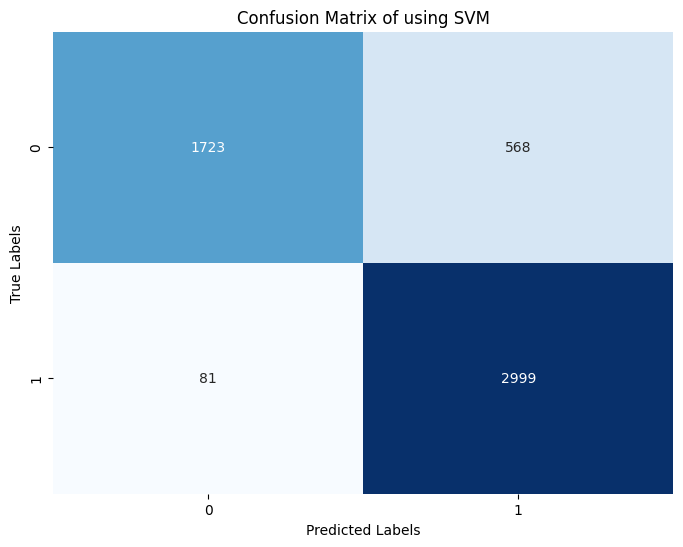

In [57]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Logistic Regression`

              precision    recall  f1-score   support

           0    0.96722   0.68267   0.80041      2291
           1    0.80634   0.98279   0.88586      3080

    accuracy                        0.85478      5371
   macro avg    0.88678   0.83273   0.84314      5371
weighted avg    0.87496   0.85478   0.84941      5371

Precision score of using Logistic Regression: 0.8867815785199147
Recall score of using Logistic Regression: 0.8327317651793863
F1-score of using Logistic Regression: 0.8431371051300185


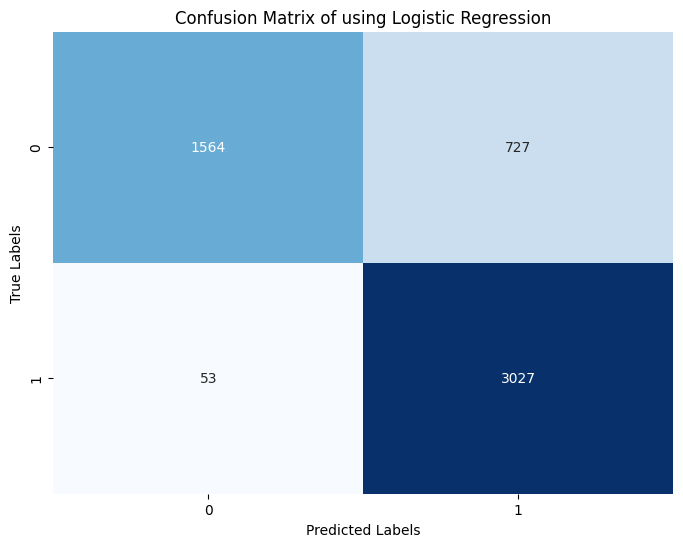

In [58]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Gaussian Naive Bayes`

              precision    recall  f1-score   support

           0    0.62312   0.97425   0.76009      2291
           1    0.96702   0.56169   0.71062      3080

    accuracy                        0.73767      5371
   macro avg    0.79507   0.76797   0.73535      5371
weighted avg    0.82033   0.73767   0.73172      5371

Precision score of using GaussianNB model: 0.7950681299173341
Recall score of using GaussianNB model: 0.7679676826883287
F1-score of using GaussianNB model 0.7353533687674102


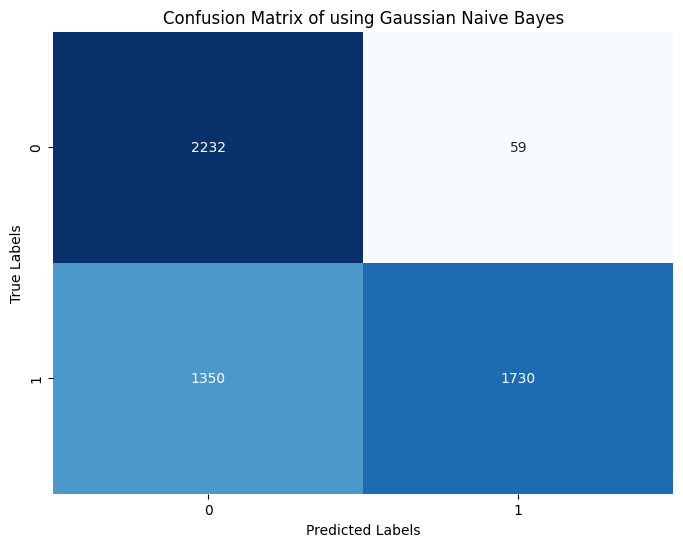

In [59]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Decision Tree Classifier`

              precision    recall  f1-score   support

           0    0.94671   0.75993   0.84310      2291
           1    0.84428   0.96818   0.90200      3080

    accuracy                        0.87935      5371
   macro avg    0.89550   0.86406   0.87255      5371
weighted avg    0.88797   0.87935   0.87687      5371

Precision score of using DecisionTreeClassifier model: 0.8954955146360133
Recall score of using DecisionTreeClassifier model: 0.8640559898416729
F1-score of using DecisionTreeClassifier model 0.8725478219218414


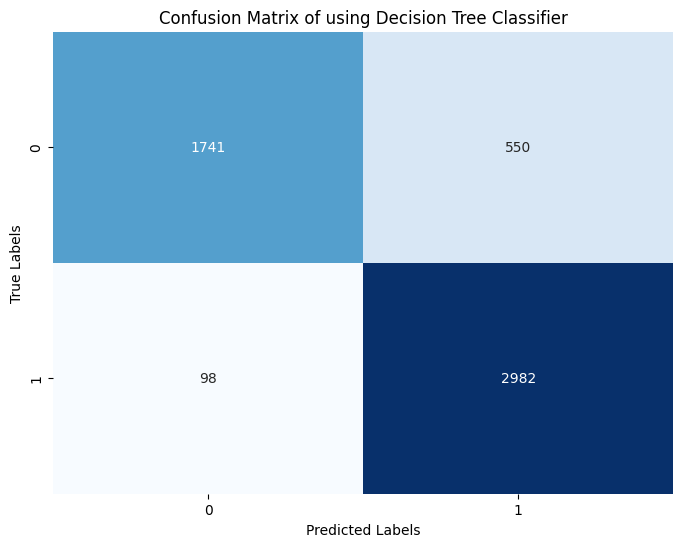

In [60]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.4. TF-IDF`

##### `Quá trình khởi tạo mô hình`

In [61]:
X = data["full_name"]
y = data["gender"]

`Term frequency-inverse document frequency (Tf-Idf) là một trong những phương pháp
được sử dụng rộng rãi hiện nay trong lĩnh vực xử lý dữ liệu văn bản. Tf-Idf thể hiện
mức độ quan trọng của một từ trong văn bản mà văn bản đang xét nằm trong một tập
hợp các văn bản.`

`Trong thư viện sklearn.feature_extraction.text có một hàm là TfidfVectorizer(), ta dùng hàm này để áp dụng mô hình TF-IDF cho đồ án.`



In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
tfidf = TfidfVectorizer()

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [64]:
tf_v= tfidf.fit_transform(np.array(X))

In [65]:
print(X)

0               Ngô Xuân Tùng
1           Bùi Dương Thảo Vy
2                 Lưu Thế Huy
3              Nguyễn Thị Vân
4             Dương Minh Long
                 ...         
26846        Đoàn Thị Bảo Thu
26847              Ôn Hoa Thu
26848    Nguyễn Thị Huỳnh Như
26849    Nguyễn Thị Hồng Phúc
26850           Dương Mỹ Uyên
Name: full_name, Length: 26851, dtype: object


`Hiển thị từ điển từ`

In [66]:
print(tfidf.vocabulary_)

{'ngô': 696, 'xuân': 1406, 'tùng': 1283, 'bùi': 53, 'dương': 222, 'thảo': 1120, 'vy': 1360, 'lưu': 565, 'thế': 1132, 'huy': 301, 'nguyễn': 687, 'thị': 1135, 'vân': 1364, 'minh': 609, 'long': 519, 'trần': 1232, 'mai': 601, 'khanh': 423, 'hồng': 388, 'diệp': 193, 'hoàng': 295, 'khang': 422, 'thi': 1042, 'ngọc': 704, 'thái': 1083, 'anh': 5, 'tường': 1295, 'nhật': 759, 'lê': 546, 'trúc': 1217, 'quỳnh': 938, 'đức': 1514, 'tấn': 1303, 'đào': 1458, 'hiếu': 277, 'thạch': 1114, 'kim': 456, 'yến': 1414, 'võ': 1367, 'thanh': 1037, 'phạm': 855, 'lệ': 585, 'chi': 95, 'đỗ': 1509, 'nghĩa': 672, 'đinh': 1439, 'dân': 212, 'huỳnh': 316, 'lý': 557, 'chương': 121, 'lương': 566, 'việt': 1353, 'mạnh': 638, 'nhi': 721, 'quốc': 937, 'khánh': 439, 'trịnh': 1239, 'trung': 1200, 'tiến': 1161, 'đạt': 1478, 'giàu': 251, 'đặng': 1487, 'duy': 201, 'mỹ': 654, 'linh': 508, 'phúc': 849, 'trang': 1185, 'văn': 1368, 'thông': 1096, 'hồ': 384, 'nhơn': 747, 'phan': 820, 'như': 748, 'trọng': 1241, 'ngôn': 698, 'cao': 86, 'th

`Hiển thị ma trận đếm`

In [67]:
print(tf_v)

  (0, 1283)	0.6708817663364364
  (0, 1406)	0.5229244208112136
  (0, 696)	0.5258019643521314
  (1, 1360)	0.5727837923939603
  (1, 1120)	0.48071502778466646
  (1, 222)	0.47303388299103216
  (1, 53)	0.46590850472512974
  (2, 301)	0.49006754623386484
  (2, 1132)	0.6151707165224523
  (2, 565)	0.6175749263543425
  (3, 1364)	0.8833687104900664
  (3, 1135)	0.346850786697043
  (3, 687)	0.31520509687306697
  (4, 519)	0.6688178561741946
  (4, 609)	0.4495981064561991
  (4, 222)	0.5920677477565846
  (5, 423)	0.7675930392078528
  (5, 601)	0.5412716989833917
  (5, 1232)	0.3432577370421309
  (6, 193)	0.7911054484875614
  (6, 388)	0.505732763732031
  (6, 1135)	0.254635315273552
  (6, 687)	0.23140310559021188
  (7, 422)	0.8090278687958811
  (7, 295)	0.5140385716808287
  :	:
  (26844, 167)	0.6166704887393115
  (26844, 855)	0.405712900767791
  (26844, 1364)	0.6279504430952964
  (26844, 1135)	0.24656194249118077
  (26845, 794)	0.7866490810342378
  (26845, 307)	0.5704536853379233
  (26845, 1135)	0.236147869

`Chia data thành 2 phần : 80% cho train và 20% cho test`

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_v, y, test_size=0.2, random_state=42, shuffle=False)

##### `Huấn luyện và đánh giá mô hình qua các mô hình máy học`

###### `SVM`

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.96464   0.92885   0.94641      2291
           1    0.94850   0.97468   0.96141      3080

    accuracy                        0.95513      5371
   macro avg    0.95657   0.95176   0.95391      5371
weighted avg    0.95538   0.95513   0.95501      5371

Precision score of using SVM: 0.9565705479383384
Recall score of using SVM: 0.9517636771783433
F1-score of using SVM 0.9539089221121171


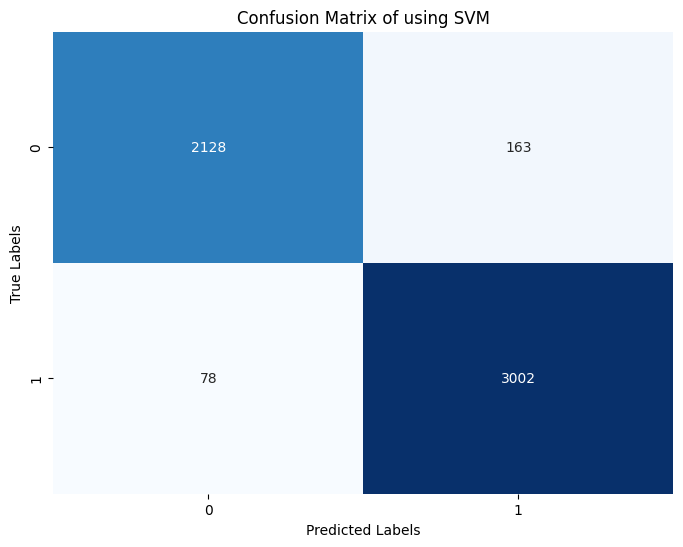

In [69]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Logistic Regression`

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0    0.96401   0.92361   0.94338      2291
           1    0.94490   0.97435   0.95940      3080

    accuracy                        0.95271      5371
   macro avg    0.95445   0.94898   0.95139      5371
weighted avg    0.95305   0.95271   0.95257      5371

Precision score of using Logistic Regression: 0.954454177974903
Recall score of using Logistic Regression: 0.948982395823295
F1-score of using Logistic Regression: 0.9513891897839599


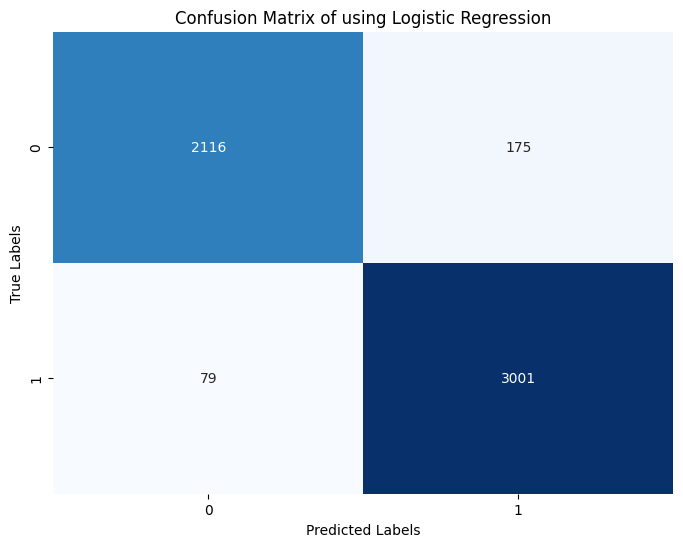

In [70]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Gaussian Naive Bayes`

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.54130   0.97250   0.69549      2291
           1    0.94980   0.38701   0.54994      3080

    accuracy                        0.63675      5371
   macro avg    0.74555   0.67976   0.62272      5371
weighted avg    0.77556   0.63675   0.61203      5371

Precision score of using GaussianNB model: 0.7455515159962676
Recall score of using GaussianNB model: 0.6797570391197628
F1-score of using GaussianNB model 0.6227158192209392


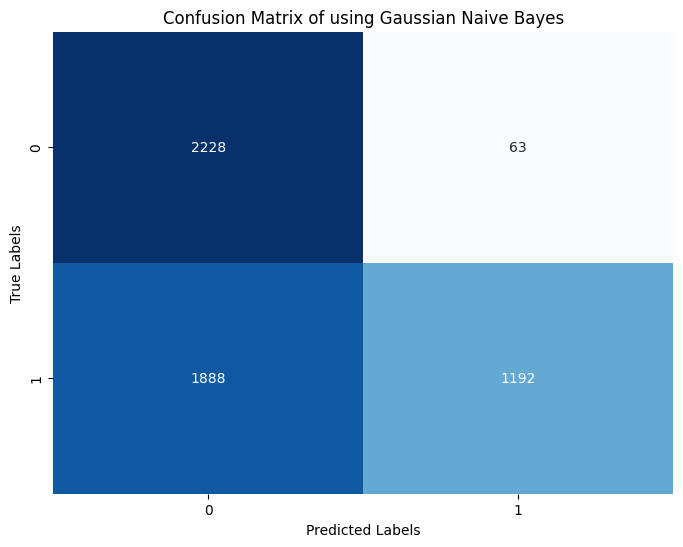

In [71]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###### `Decision Tree Classifier`

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0    0.91320   0.90921   0.91120      2291
           1    0.93269   0.93571   0.93420      3080

    accuracy                        0.92441      5371
   macro avg    0.92294   0.92246   0.92270      5371
weighted avg    0.92437   0.92441   0.92439      5371

Precision score of using DecisionTreeClassifier model: 0.9229410254118375
Recall score of using DecisionTreeClassifier model: 0.9224621188501589
F1-score of using DecisionTreeClassifier model 0.922698165565609


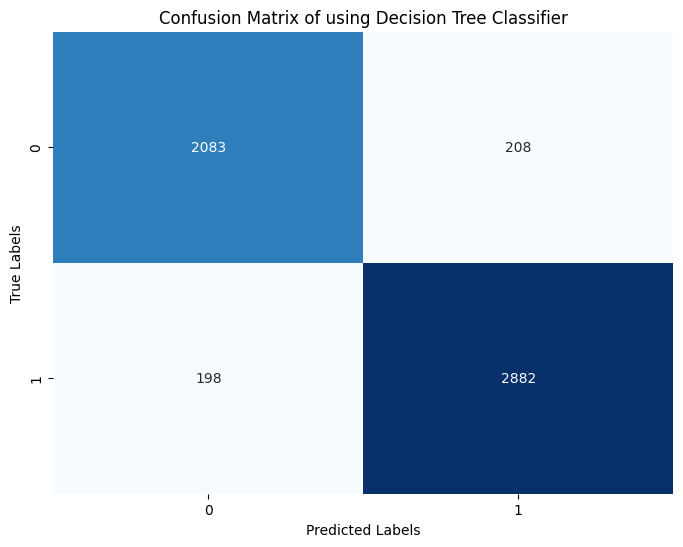

In [72]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### `Trường hợp xoá bỏ họ ra khỏi họ và tên`

###### `Code`

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`
`Xoá họ ra khỏi data:`

In [73]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Xuân Tùng', 'Thảo Vy', 'Thế Huy', 'Thị Vân', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Hoàng Khang', 'Ngọc Thái', 'Anh Huy', 'Tường Vy', 'Minh Nhật', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Đức Mạnh', 'Yến Nhi', 'Quốc Khánh', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Quốc Duy', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Văn Khánh', 'Minh Thông', 'Hiếu Nhơn', 'Minh Dương', 'Quỳnh Như', 'Anh Hiếu', 'Văn Trọng', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Huy Hoàng', 'Thúy Kiều', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Quốc Anh', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thùy Linh', 'Thiên Phước', 'Quang Tuấn', 'Thanh Tuyền', 'Xuân Tùng', 'Huy Phong', 'Ngọc Giàu', 'Như Minh', 'Thanh Quí', 'Trọng Tài', 'Công Danh', 'Quang Hào', 'Hữu Tài', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Huyền Trân', 

`Tổng hợp lại những bước ở trên trong 1 đoạn code`

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer()
tf_v= tfidf.fit_transform(X_erase_surname)
X_train, X_test, y_train, y_test = train_test_split(tf_v, y, test_size=0.2, random_state=42, shuffle=False)

###### `SVM`

              precision    recall  f1-score   support

           0    0.93608   0.91401   0.92491      2291
           1    0.93714   0.95357   0.94528      3080

    accuracy                        0.93670      5371
   macro avg    0.93661   0.93379   0.93510      5371
weighted avg    0.93669   0.93670   0.93659      5371

Precision score of using SVM: 0.9366080672018632
Recall score of using SVM: 0.9337913886637152
F1-score of using SVM 0.9350982507298577


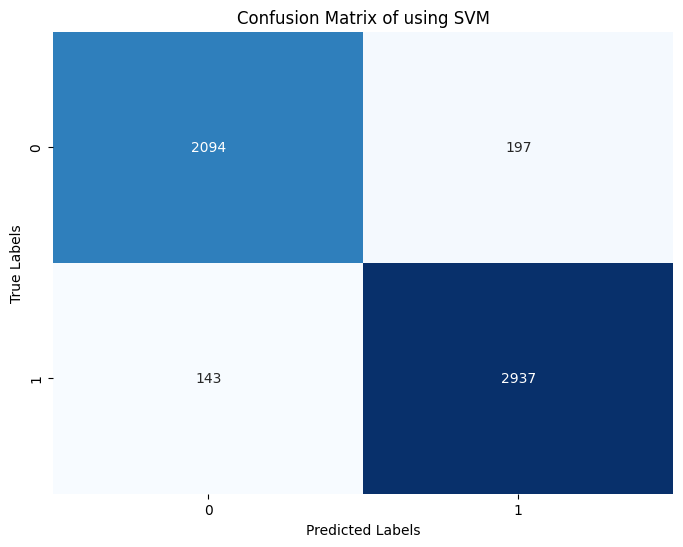

In [75]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using SVM:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using SVM:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using SVM", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Logistic Regression`

              precision    recall  f1-score   support

           0    0.94017   0.91227   0.92601      2291
           1    0.93615   0.95682   0.94637      3080

    accuracy                        0.93781      5371
   macro avg    0.93816   0.93454   0.93619      5371
weighted avg    0.93787   0.93781   0.93769      5371

Precision score of using Logistic Regression: 0.9381604383192693
Recall score of using Logistic Regression: 0.9345417840561883
F1-score of using Logistic Regression: 0.9361896009531753


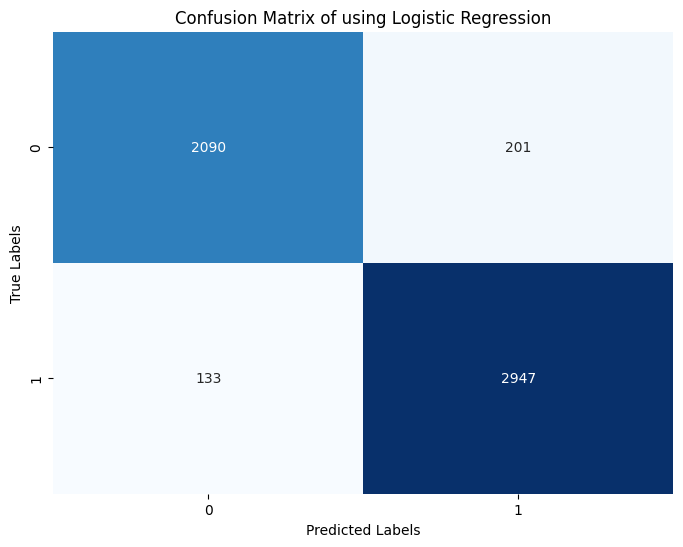

In [76]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Gaussian Naive Bayes`

              precision    recall  f1-score   support

           0    0.56859   0.97337   0.71785      2291
           1    0.95790   0.45065   0.61294      3080

    accuracy                        0.67362      5371
   macro avg    0.76324   0.71201   0.66539      5371
weighted avg    0.79184   0.67362   0.65769      5371

Precision score of using GaussianNB model: 0.7632447283800852
Recall score of using GaussianNB model: 0.7120117115533964
F1-score of using GaussianNB model 0.6653942543211964


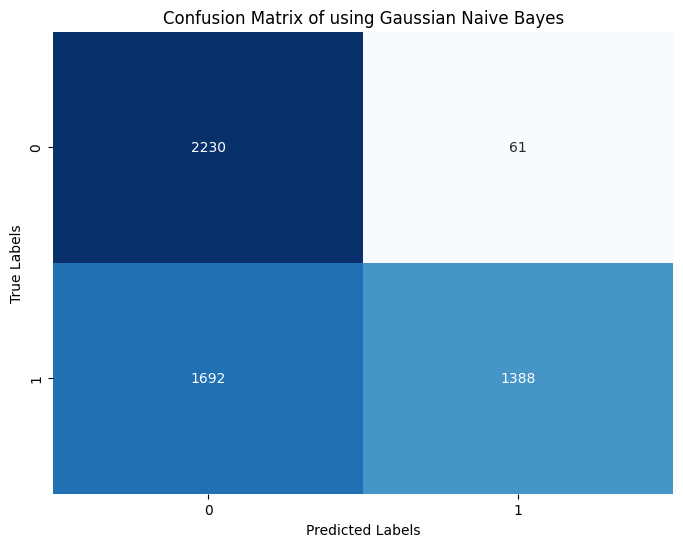

In [77]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using GaussianNB model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using GaussianNB model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using GaussianNB model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

######`Decision Tree Classifier`

              precision    recall  f1-score   support

           0    0.90528   0.91357   0.90941      2291
           1    0.93527   0.92890   0.93207      3080

    accuracy                        0.92236      5371
   macro avg    0.92027   0.92124   0.92074      5371
weighted avg    0.92248   0.92236   0.92241      5371

Precision score of using DecisionTreeClassifier model: 0.9202748908151226
Recall score of using DecisionTreeClassifier model: 0.921235481018327
F1-score of using DecisionTreeClassifier model 0.9207402680822796


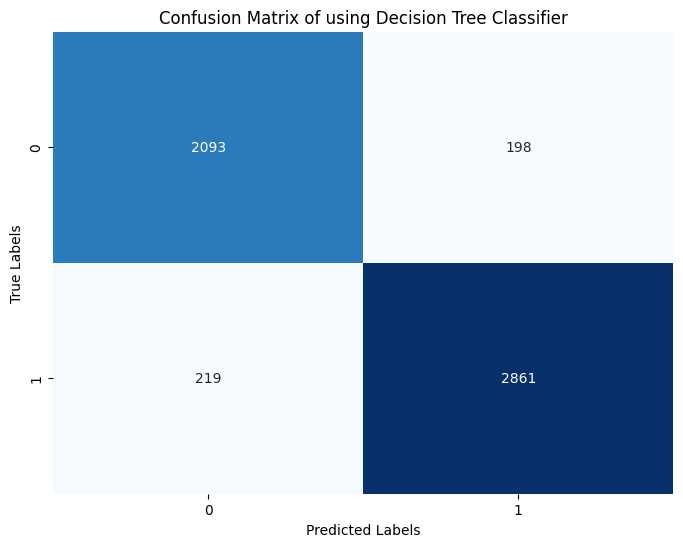

In [78]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using DecisionTreeClassifier model:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using DecisionTreeClassifier model:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using DecisionTreeClassifier model", f1_score(y_test, y_pred, average='macro'))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##**`IV. Kết luận`**


`Sau khi đã xem xét và áp dụng tất cả những gì mà nhóm đã nghiên cứu và thực hiện
được. Kết quả thu được tốt nhất của nhóm đó là f1-score đạt max là 94.77%, sử dụng
mô hình Logistic Regression, trích chọn đặc trưng là Bag-of-words và không bỏ đi phần họ trong họ
và tên.`

`Ngoài ra, khi thử bỏ phần họ trong họ và tên đi thì performance của các mô hình máy
học kết hợp các trích chọn đặc trưng cho văn bản lại bị giảm đi.`



`Xem qua một số họ và tên bị đoán nhầm ở trường hợp đoán được kết quả như sau:`